## Part 2 - SVD and PCA

In the previous part we introduced you to dimensionality reduction and we showed you how you can do it with simple heuristics, feature engineering, and even with statistical methods. But, as mentioned, these methods lack information such as interaction between features and can be over-simplified for our purposes. This is where algebra kicks in to help us out.

![morpheus-algebra](../media/what-if-i-told-you.jpg)


Never thought you'd use algebra again, right? Guess again, Neo.

In [2]:
import string
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from pylab import barh,plot,yticks,show,grid,xlabel,figure,cla,close
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from nltk.tokenize import WordPunctTokenizer
from scipy.sparse.linalg import svds
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2

seed = 42

## 1. Singular Value Decomposition

The Singular Value Decomposition (SVD) method is a matrix decomposition or matrix factorization method, often used in applications such as compression, denoising and, our current topic, dimensionality reduction. All matrices have an SVD, making it more stable than other methods, such as the eigendecomposition. It is often presented with Principal Component Analysis (PCA), which we are going to dive into later, but it can actually be used by itself, so let's start with that.

The concept of SVD is relatively straightforward, but it is useful to understand the algebra behind it. I was actually going to assume you are fresh on your basic algebra (don't roll your eyes at me), skip the primers and jump right to business, but then again, a little refresher doesn't hurt. 

### Basic Algebra

<img src="../media/welcome-to-the-matrix.jpg" width="400">

A matrix is just a collection of values ordered in rows and collumns, such as the one that you created with count vectorizer or Tf-idf vectorizer.

$$
A = \begin{bmatrix} 
    x_{11}&x_{12}&.&.&.&.&x_{1N}\\
    x_{21}&x_{22}&.&.&.&.&x_{2N}\\
    .&.&.&.&.&.&.\\
    x_{M1}&x_{m2}&.&.&.&.&x_{MN}\\
\end{bmatrix}
$$

It has a known shape - in our case above M-by-N. Remember that a 1-by-N or M-by-1 shaped matrix is what we normally call a vector. There are also some typical operations that you compute usually, in particular with the help of numpy, like the transpose:

$$
A = \begin{bmatrix} 
    a & b & c\\
    d & e & f \\
\end{bmatrix}
\quad A^T = \begin{bmatrix} 
    a & d \\
    b & e \\
    c & f 
\end{bmatrix}
$$

or the dot product, where the internal dimensions have to match:

$$
A = \begin{bmatrix} 
    a & b\\
\end{bmatrix} 
\quad B = \begin{bmatrix} 
    c \\ 
    d \\
\end{bmatrix} 
\quad AB = \begin{bmatrix} 
    ac + bd 
\end{bmatrix} 
\quad A^T B^T = \begin{bmatrix} 
    ac & bc \\ 
    ad & bd \\
\end{bmatrix}
$$

An important concept is also the determinant of a matrix, an operation applicable to squared matrix that yields a scalar value, that can be seen geometrically as the scaling factor of the linear transformation described by the matrix. For simple matrices, like 2-by-2 and 3-by-3, the expressions seem fairly simple:

$$ A = \begin{bmatrix} 
    a & b \\
    c & d \\
\end{bmatrix}
\quad|A| = ad − bc 
\quad \quad B = \begin{bmatrix} 
    a & b & c\\
    d & e & f \\
    g & h & i \\
\end{bmatrix}
\quad|B| = a(ei − fh) - b(di − fg) + c(dh − eg)
$$

But for matrices with higher number of rows or collumns, these formulas will complicate. For all these operations, if you wish to understand more about algebra, you'll have to study a bit. But for now, this should suffice to grasp the mathematics behind the SVD. First, try out a few of these operations (in particular the determinant) with numpy.

In [2]:
A = np.array([
    [1, 2],
    [3, 4],
    [1, 2],
    [1, 2],
    [3, 4],
    [1, 2],
])

# Print transpose
A_T = A.T
print(A_T)

# Use matrix multiplication
# np.multiply is the element-wise multiplication, while np.dot or np.matmul are matrix multiplications
A_mul = np.matmul(A, A_T)

# Compute determinant of 6x6 matrix
np.linalg.det(A_mul)

[[1 3 1 1 3 1]
 [2 4 2 2 4 2]]


0.0

### Eigenvalues and Eigenvectors

An eigenvector is a vector whose direction remains unchanged when a linear transformation is applied to it. If we consider a linear transformation as being represented by some matrix $M$, then what this mean is that the product of this matrix by the eigenvector $v$ will just be a scaled version of $v$:

$$Mv=\lambda v$$

In this definition we exclude the zero-vector, since the multiplication would always be true for any scalar $ \lambda $. A method for finding the vectors $v$ - the **eigenvectors** - and their scalar counterparts $\lambda$ - the **eigenvalues** - is to treat the above as a linear system, and solve it. We are not going to do a demonstration on this method because the most common way of solving this is actually through algebra, using the determinant. We will not go deeper into how to compute this, since numpy makes it super easy, but you should at least understand its reasoning and know the basic equation that defines them.

In [3]:
# Compute eigenvalues and vectors of square matrix
lmbU, U = np.linalg.eig(A_mul)

print(lmbU)
print(U)

[ 6.95398321e+01 -1.21655365e-15  4.60167922e-01  5.25800857e-18
 -1.75191965e-34  1.84200367e-31]
[[-2.65922637e-01 -8.66025404e-01  4.23420773e-01  1.65446623e-03
   7.66864040e-06 -5.36440652e-03]
 [-5.98807400e-01 -2.18166397e-15 -3.76071400e-01 -7.07105491e-01
   7.29408554e-04 -5.10239599e-01]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01 -5.51488743e-04
   8.05501321e-04 -5.63468400e-01]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01 -5.51488743e-04
  -7.07512644e-01  2.84808086e-01]
 [-5.98807400e-01 -2.00819163e-15 -3.76071400e-01  7.07105491e-01
  -7.29408554e-04  5.10239599e-01]
 [-2.65922637e-01  2.88675135e-01  4.23420773e-01 -5.51488743e-04
   7.06699474e-01  2.84024721e-01]]


## 1.1) Defining the Singular Value Decomposition (SVD)

The SVD of a matrix $A$ is just its factorization into the product of three matrices, $U$, $S$, and $V$ where the columns of U and V are orthonormal and $S$ is diagonal with positive real entries, described by the following:

$$ A = USV^T $$
 
* $A$: matrix we want to decompose (consider $A$ an M-by-N matrix)
* $U$: orthonormal$^1$ matrix composed by eigenvectors of  $AA^T$. These eigenvectors are also called the 'left-singular' values of A. ($U$ is M-by-M)
* $V^T$: orthonormal$^1$ matrix composed by eigenvectors of $A^TA$. These eigenvectors are also called the 'right-singular' values of A. ($V$ is N-by-N)
* $S$: diagonal matrix containing the square root of nonzero eigenvalues of $U$ (or $V$), ordered by decreasing size ($S$ is M-by-N). It is a property of these matrices that the nonzero eigenvalues of $U$ and $V$ are the same, this is, the eigenvectors of  $AA^T$ and $A^TA$ are related.

$^1$ Orthonormal matrices have the following property: $VV^T = I$. This is, their product by its transpose produces the identity matric.

<br>

Let's try to perform a decomposition then. First, let's define a matrix A.

### 1 - Choose A

Lets create a very simple matrix  A imagining we have a bunch of reviews that we classify as positive or negative from the words that appear there.

|          |  like | hate | not | love |
|----------|-------|------|-----|------|
| Positive |  5    |  0   |  2  |   4  |
| Negative |  2    |  6	  |  1  |   2  |


You can see how this matrix can grow with the number of examples, and the number of n-grams considered, which will typically lead to a higher vocabulary. Thus, you can understand why it is desirable to simplify it.

Start by defining the matrix:

In [4]:
A = np.array([
    [5, 0, 2, 4],
    [2, 6, 1, 2]
])

print("\nMatrix to decompose:")
print(A)


Matrix to decompose:
[[5 0 2 4]
 [2 6 1 2]]


Let's now create U, V and S from what we learned above:

### 2 - Build U 

Remember that $U$ is composed by the eigenvectors of  $AA^T$.


In [5]:
AT = A.T
AAT = np.matmul(A, AT)

lmbU, U = np.linalg.eig(AAT)

print("\nEigenvectors:")
print(U)
print("\nEigenvalues:")
print(lmbU)


Eigenvectors:
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]

Eigenvalues:
[65. 25.]


### 3 - Build $V^T$

Remember that $V^T$ is composed by the eigenvectors of  $A^TA$.

In [6]:
ATA = np.matmul(AT, A)

lmbV, V = np.linalg.eig(ATA)

print("\nEigenvectors:")
print(V)
print("\nEigenvalues:")
print(lmbV)


Eigenvectors:
[[-0.61394061  0.42426407 -0.65212952  0.02882113]
 [-0.52623481 -0.84852814 -0.05434413  0.00240176]
 [-0.26311741  0.14142136  0.14677136  0.87917782]
 [-0.52623481  0.28284271  0.74177622 -0.47561532]]

Eigenvalues:
[ 6.50000000e+01  2.50000000e+01 -3.82164848e-15 -3.38886760e-17]


You can see that these are basically the same eigenvalues that of $U$, padded with near-zero values at the end. We are only missing $S$ now, so let's build it. 

### 4 - Create S

Take the square-roots of the nonzero eigenvalues and place them on the diagonal of a matrix size M-by-N, padding with zeros.

In [7]:
S_shape = A.shape

# Pick which lmb to use (higher rank)
lmb = lmbV if lmbV.shape[0] > lmbU.shape[0] else lmbU

# Cut off to the correct dimensions
S = np.sqrt(np.diag(abs(lmb))[:S_shape[0],:S_shape[1]])

print("S matrix:")
print(S)

S matrix:
[[8.06225775 0.         0.         0.        ]
 [0.         5.         0.         0.        ]]


You can now check that the factorization was successful and assure that $A = USV^T$ 

In [8]:
print("Original matrix:")
print(A)

USVT = np.matmul(np.matmul(U, S), V.T)

print("\nFactorization U S V^T")
print(USVT)

Original matrix:
[[5 0 2 4]
 [2 6 1 2]]

Factorization U S V^T
[[-5.  0. -2. -4.]
 [-2. -6. -1. -2.]]


You can see that we got to the same values of the initial matrix, scaled by a factor of -1. This is an ambiguity of the SVD problem, but there are ways to solve it. However, for our problem, you could simply consider that, knowing we are dealing with counts (if we are using CountVectorizer) or just a scaled version of it (TfIdfVectorizer), the values must be positive, and we could simply use that information to always disambiguate the sign:

In [9]:
sign = USVT.sum()/abs(USVT.sum())

print("Matrix sign:")
print(sign)

USVT_disambiguated = sign * USVT
print("\nFactorization U S V^T disambiguated:")
print(USVT_disambiguated)

Matrix sign:
-1.0

Factorization U S V^T disambiguated:
[[ 5. -0.  2.  4.]
 [ 2.  6.  1.  2.]]


Notice that this method to disambiguate is only value inside our context, but there are other ways of solving this problem.

If you still want a deeper mathematical explanation you can start with this __[chapter](http://www.deeplearningbook.org/contents/linear_algebra.html)__, or if you've completely forgot algebra and want to relearn it you can also try this __[course](https://ocw.mit.edu/courses/mathematics/18-06-linear-algebra-spring-2010/index.htm)__.

![neo-algebra](../media/i-know-linear-algebra.jpg)


### Using SVD for dimensionality reduction

Now that you know what's under the hood for SVD you probably want to make some use of this, so we will show you how to use it to perform feature reduction. It is actually quite simple. Let's take a step back. Because of the orthonormal property of our matrix $V$ we can write the SVD equation as:

$$ AV=US $$

We could now assume a truncation of k components (let's say, to 1 component) and get the following:

$$ A\begin{bmatrix}v_{11}\\v_{21}\\.\\.\\v_{n1}\end{bmatrix} = s_{11}\begin{bmatrix}u_{11}\\u_{21}\\.\\.\\u_{m1}\end{bmatrix} $$

The vector $v$ is what we call a projection direction. The result of multiplying $X$ by this direction will result in a matrix with the same number of rows, but a smaller number of columns. Your data would now be projected in the first direction, this is, the one holding more variance. We could then get an approximation of X by computing:

$$ A \approx s_{11}\begin{bmatrix}u_{11}\\u_{21}\\.\\.\\u_{m1}\end{bmatrix}\begin{bmatrix}v_{11}&v_{21}&.&.&v_{n1}\end{bmatrix} $$

So you could now extend this for k components. By selecting the first k eigenvalues in S and assuming the others to be zero, you can use any subselection to reconstruct an approximate version of  A, with:

$$ A^{*}=U^{*}S^{*}{V^{*}}^{T} $$

Where $S^{*}$ is reduced to keep the first k eigenvalues and both $U^{*}$ and ${V^{*}}^{T}$ are reduced such that the dimensions are consistent. But this reconstruction isn't actually what we want. What we want is the projection of our data into a smaller space. In the same way that with 1 component multiplying by $V$ gave us the projected data, the same holds for k components, and all we need to do is project given $V$:


$$ A_r = A {V^{*}} $$






By selecting the first k eigenvalues we ensure that  $A^{*}$ retains a disproportionately high amount of the variance of  A; we have in effect compressed the original information and represented it using fewer features. This is often used in NLP and known in that context as LSA - Latent Semantic Analysis


##  1.2 ) Putting it all together

Let's put together all the steps we've seen and try out dimensionality reduction with SVD:

In [10]:
def get_svd_decomposition(A):
    AT = A.T
    AAT = np.matmul(A, AT)
    ATA = np.matmul(AT, A)

    lmbU, U = np.linalg.eig(AAT)
    lmbV, V = np.linalg.eig(ATA)

    S_shape = A.shape
    lmb = lmbV if lmbV.shape[0] > lmbU.shape[0] else lmbU
    S = np.sqrt(np.diag(abs(lmb))[:S_shape[0],:S_shape[1]])
    
    return U, S, V


def get_svd_reduction_counts(A, n_components, debug=False):
    
    U, S, V = get_svd_decomposition(A)
    
    USVT = np.matmul(np.matmul(U[:, :n_components], S[:n_components, :n_components]), V.T[:n_components,:])
    
    # Assuming our initial matrix A holds counts or scaled counts
    sign = USVT.sum()/abs(USVT.sum())
    USVT_disambiguated = sign * USVT

    if debug:
        print("Reconstruction from {} components".format(n_components))
        print(USVT_disambiguated)

    reduction = np.matmul(A, V[:,:n_components])
    return reduction, V.T[:n_components,:]


As before, let's start with a simple A, from a bunch of reviews. We will now add to extra feature that we'll define in an agnostic way regarding the positive/negative reviews:

|          |  like | hate | not | love | movie | book |
|----------|-------|------|-----|------|-------|------|
| Positive |  5    |  0   |  2  |   4  |   1   |   0  |
| Negative |  2    |  6	  |  1  |   2  |   0   |   1  |  
| Positive |  3    |  1   |  1  |   4  |   2   |   1  |
| Negative |  2    |  6	  |  1  |   5  |   0   |   2  |
| Negative |  0    |  0   |  3  |   1  |   0   |   0  |
| Negative |  2    |  4	  |  0  |   1  |   1   |   0  |

Let's define our matrix as a numpy array:


In [11]:
A = np.array([
    [5, 0, 2, 4, 1, 0],
    [2, 6, 1, 2, 0, 1],
    [3, 1, 1, 4, 2, 2],
    [2, 6, 1, 5, 0, 2],
    [0, 0, 3, 1, 0, 0],
    [2, 4, 0, 1, 1, 0],
])

We can now use our functions to get a reduction and compute the variance each reduction holds.

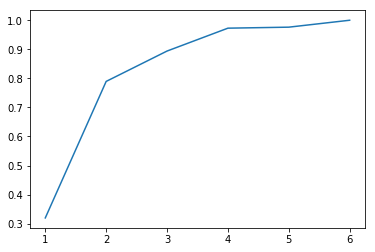

In [12]:
variance = []

for n in range(6):
    A_red, VT = get_svd_reduction_counts(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance))

As you see, the variance increases up until 4 features and then stabilizes. However, be mindful that the number of components is not directly related to the components in our table. We did add two components at the end that we know shouldn't have a huge impact, and this results seems to make sense in the sense that 4 components computed from the SVD would be enough to cover almost the entire set's variance.

But if you reorder the collumns or if you have further relations between your features you could even see 2 components holding the entire variance. See what happens when we copy the values in "like" to "love" and "hate" to "not":

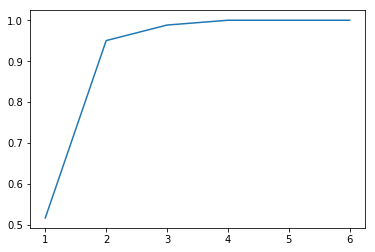

In [13]:
A = np.array([
    [5, 0, 0, 5, 1, 0],
    [2, 6, 6, 2, 0, 1],
    [3, 1, 1, 3, 2, 2],
    [2, 6, 6, 2, 0, 2],
    [0, 0, 0, 0, 0, 0],
    [2, 4, 4, 2, 1, 0],
])

variance = []

for n in range(6):
    A_red, VT = get_svd_reduction_counts(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance))

As you can see, you can in fact attribute most of the variance to only two components, at about 95%. As a rule of thumb, you should aim at keeping over 85% of the variance explained. So our 95% result is actually very good, and it should show you that the SVD actually extracts meaningful features from your data. Feeling pretty awesome there, Neo?

<img src="../media/neo-dodging-bullets.jpg" width="400">


Unfortunetely not all cases - in particular, real cases - are so straightforward. Instead of using our implementation, we will move to the scikitlearn version, where you can use the TruncatedSVD class to apply this technique to your data, with more additional options. We will try it out with the data from the previous example

## 2.  SVD - NLP practical example 

## 2.1 - Start from baseline

As before, start by importing the dataset and getting a baseline. We will change from the multinomial naive Bayes we were using to a classifier that can handle negative numbers, because of the output of SVD. For now let us use a KNeighborsClassifier, which will try to classify the test points by it's proximity to training examples. This is a very good classifier to make the case for dimensionality reduction, since in a very high-dimensional space, the vector distances will most of the times be useless.

In [35]:
# Fetch dataset
df = pd.read_csv('../datasets/twitter_rep_dem_data_small.csv')

# Feature Extraction
handle_remotion = lambda doc: re.subn(r'@\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(handle_remotion)

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['Tweet'] = df['Tweet'].map(simple_tokenizer)

train_data, test_data = train_test_split(df,  test_size=0.3, random_state=seed)
      
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data.Tweet)
X_test = vectorizer.transform(test_data.Tweet)

# Baseline
clf =  KNeighborsClassifier()
clf.fit(X_train, train_data.Party)
pred = clf.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(pred, test_data.Party)))

Accuracy: 0.5062994960403168


That's a pretty low baseline, as expected. It is actually similar to just randomly attribute classes to our examples. Let's see if keeping the same algorithm we can get to some decent values by reducing the dimensionality of the data.

## 2.2 - Applying SVD

We will now use the scikit-learn truncatedSVD class to obtain an SVD reduction of our data. This step might take a few minutes (~10 min), so just go ahead and grab a coffee, think about the nature of your reality, maybe try to bend some spoons, whatever makes you happy.

In [22]:
true_variance = []
explained_variance = []
accuracies = []

dense_X_train = X_train.toarray()
data_var = np.var(dense_X_train, axis=0).sum()

print('Total variance:')
print(data_var)

for n in [2, 10, 100, 200, 500, 1000]:
    print("\nComputing SVD for {} components".format(str(n)))
    svd = TruncatedSVD(n_components=n, random_state=seed)
    % timeit svd.fit(X_train)
    X_train_svd = svd.transform(X_train)
    X_test_svd =  svd.transform(X_test)
    print('\nVariance:')
    print(np.var(X_train_svd, axis=0).sum())
    true_variance.append(1.0*np.var(X_train_svd, axis=0).sum() / data_var)
    explained_variance.append(svd.explained_variance_)
    
    clf =  KNeighborsClassifier()
    clf.fit(X_train_svd, train_data.Party)
    pred = clf.predict(X_test_svd)
    
    accuracies.append(accuracy_score(pred, test_data.Party))
    print('Accuracy: {}'.format(accuracy_score(pred, test_data.Party)))

Total variance:
0.9819072349956481

Computing SVD for 2 components
75.8 ms ± 4.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Variance:
0.007960307080658226
Accuracy: 0.5205183585313174

Computing SVD for 10 components
162 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Variance:
0.032902285907870796
Accuracy: 0.5468682505399568

Computing SVD for 100 components
1.39 s ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.15797470414476908
Accuracy: 0.5949244060475162

Computing SVD for 200 components
2.67 s ± 276 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.23466282376254957
Accuracy: 0.5913606911447085

Computing SVD for 500 components
8.61 s ± 604 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.37589910822608485
Accuracy: 0.5871490280777538

Computing SVD for 1000 components
23.7 s ± 448 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.5127082415863743
Accuracy: 0.553563714

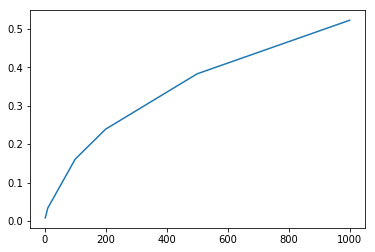

In [19]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(true_variance))
plt.title("SVD Variance")

Text(0.5,1,'SVD Accuracy')

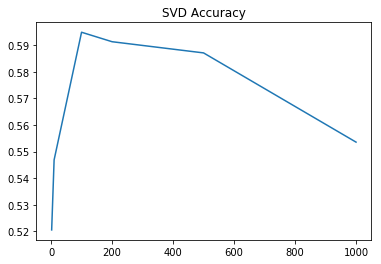

In [24]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(accuracies))
plt.title("SVD Accuracy")

These results should show you that high dimensionality can sometimes reduce your performance. In this particular case, neither a high number of features nor a too low number of features result in good performance. Let's move forward to our second method, which is highly related to the SVD - principal component analysis, and see if the results hold.

## 3. Principal Component Analysis


This idea of applying Principal Component Analysis for dimensionality reduction is very similar to the one of SVD. In fact, SVD can be used just as a mathematical way of solving PCA and several numerical software libraries actually use SVD under the hood for their PCA routines - take as example the scikit-learn implementation. So what is PCA?

In the same way as before, PCA aims to project the data into a lower dimensionality space, maximizing the variance of the projection along each component while minimizing the reconstruction error. We need to introduce a new concept - the covariance matrix and the correlation matrix.

Given our training set as a sequence of data points $\{x^1, x^2, ..., x^K\}$, a matrix $A$ that represents this dataset, and its mean as $\mu = \langle A \rangle$, the covariance matrix is represented by:

$$cov(A) = \langle(A - \mu)(A - \mu)^T\rangle = \frac{(A - \mu)(A - \mu)^T}{n-1}$$

where each row is a variable and each collumn an observation, and the correlation matrix is simply

$$corr(A) = \langle A A^T\rangle$$

In the study of principal components, we are interested in the variation of the data about the mean, so we normally first compute the centered data:

$$ \bar{A} = A - \mu$$

with the result that $cov(\bar{A}) = corr(\bar{A})$, since the data will have zero mean.


## 3.1) Getting the first principal component

We can define now the first component as projection of our data in some direction, writing it in function of some vector $\textbf{w}$, where the scale doesn't matter since it does not affect the information contained in this component:

$$p_1 = \textbf{w}^T \bar{A}$$

<br>

-------

(If you still feel you need to review the basics of algebra, skip the next few equations from now and read directly the TL,DR)

We choose this vector to maximize the variance of $p_1$:

$$\sigma^2_{p_1} = \langle p_1^2 \rangle = \langle (\textbf{w}^T \bar{A})(\bar{A}^T\textbf{w}) \rangle = \textbf{w}^T \langle \bar{A} \bar{A}^T\rangle \textbf{w} = \textbf{w}^T cov(A) \textbf{w} $$

If we define our vector $\textbf{w}$ as a linear combination of the eigenvectors of our covariance matrix, with weights $w_i$ an eigenvectors $\textbf{v}_i$:

$$\textbf{w} = \sum_i{w_i \textbf{v}_i}$$

$$\sigma^2_{p_1} = \textbf{w}^T cov(A) (\sum_i{w_i \textbf{v}_i}) = \sum_i{w_i \textbf{w}^T cov(A)\textbf{v}_i}$$

Remember that one of the main definitions of eigenvectors is that their direction remains unchanged when applying the linear transformation ($Mv=\lambda v$). Also note that, if $\textbf{v}_i$ are vectors from an orthonormal basis, then $\textbf{v}_i\textbf{v}_j = 0$ and $\textbf{v}_i\textbf{v}_i = 1$, so we can write:

$$\textbf{w}^T \textbf{v}_i = w_i $$

And our previous result simplifies to:

$$\sigma^2_{p_1} = \sum_i{w_i \lambda_i \textbf{w}^T \textbf{v}_i} = \sum_i{w_i^2 \lambda_i}  $$

This is the quantity we want to maximize, constrained to $\sum_i{w_i^2} = 1 $, so it should be clear that the maximum should be attained by setting $w_i = 1$ for the highest eigenvalue of $cov(A)$ and zero to all other weights. The first component will then be:

$$ p_1 = \textbf{v}_1 \bar{A}$$

And a reconstruction of $\bar{A}$ would be obtained by:

$$ \bar{A} =  p_1 \textbf{v}_1$$

And the variance of this compoment will just be $\sigma^2_{p_1} = \lambda_i$ for the highest eigenvalue.

-------

<br>

### **TL,DR**: 
You can write out the first component as a function of the eigenvectors and eigenvalues of the covariance matrix of $\bar{A}$, if these are ordered from highest eigenvalue to lowest: 

$$p_1 = \textbf{v}_1 \bar{A}$$

and the variance associated to this component will be:

$$\sigma^2_{p_1} = \lambda_1$$

This can be extended to the following components, and so the procedure to get a PCA reduction is quite simple. Let's try it out like we did for PCA.

### 1 - Choose A

Lets reuse the same matrix  A that we had before:

|          |  like | hate | not | love |
|----------|-------|------|-----|------|
| Positive |  5    |  0   |  2  |   4  |
| Negative |  2    |  6	  |  1  |   2  |


In [6]:
A = np.array([
    [5, 0, 2, 4],
    [2, 6, 1, 2]
])

print("\nMatrix to decompose:")
print(A)


Matrix to decompose:
[[5 0 2 4]
 [2 6 1 2]]


### 2 - Center A and compute the covariance matrix

We now need to center our data. First, be careful with the dimension you choose - you want to average across examples and get a vector with the size of your feature space. Then we can compute the covariance matrix: 


In [11]:
u = np.mean(A, axis=0)

centA = A - u

print("\nCentered data:")
print(centA)

# The covariance is an average of (A - u)(A -u)^T and it is def
covA = np.matmul(centA.T, centA)/A.shape[0]

print("\nCovariance Matrix:")
print(covA)


Centered data:
[[ 1.5 -3.   0.5  1. ]
 [-1.5  3.  -0.5 -1. ]]

Covariance Matrix:
[[ 2.25 -4.5   0.75  1.5 ]
 [-4.5   9.   -1.5  -3.  ]
 [ 0.75 -1.5   0.25  0.5 ]
 [ 1.5  -3.    0.5   1.  ]]


### 3 - Get the covariance matrix eigenvalues 

In [12]:
lmbV, V = np.linalg.eig(covA)
print(V)

[[-0.90553851 -0.42426407 -0.34291006 -0.14142136]
 [-0.39755349  0.84852814 -0.15054588  0.28284271]
 [ 0.06625892 -0.14142136 -0.80272583  0.42426407]
 [ 0.13251783 -0.28284271  0.46409037  0.84852814]]


### 4 - Project data in first component

In [14]:
A_red = np.matmul(centA, V[:, 0])

print(A_red)

[ 2.22044605e-16 -2.22044605e-16]


## 3.2 ) Putting it all together

Let's put these steps together and try out dimensionality reduction with PCA:

In [21]:
def get_pca_reduction(A, n_components):
    
    u = np.mean(A, axis=0)
    covA = np.matmul(A.T, A)
    lmbV, V = np.linalg.eig(covA)
    V_red = V[:,:n_components]
    A_red = np.matmul(A, V_red)
    var = lmbV

    return A_red, V_red, var

Once again, we are going to reuse the matrix from the SVD example:

|          |  like | hate | not | love | movie | book |
|----------|-------|------|-----|------|-------|------|
| Positive |  5    |  0   |  2  |   4  |   1   |   0  |
| Negative |  2    |  6	  |  1  |   2  |   0   |   1  |  
| Positive |  3    |  1   |  1  |   4  |   2   |   1  |
| Negative |  2    |  6	  |  1  |   5  |   0   |   2  |
| Negative |  0    |  0   |  3  |   1  |   0   |   0  |
| Negative |  2    |  4	  |  0  |   1  |   1   |   0  |

Let's define our matrix as a numpy array:

In [22]:
A = np.array([
    [5, 0, 2, 4, 1, 0],
    [2, 6, 1, 2, 0, 1],
    [3, 1, 1, 4, 2, 2],
    [2, 6, 1, 5, 0, 2],
    [0, 0, 3, 1, 0, 0],
    [2, 4, 0, 1, 1, 0],
])

We will now plot the variance and see how different components have different variances

(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)


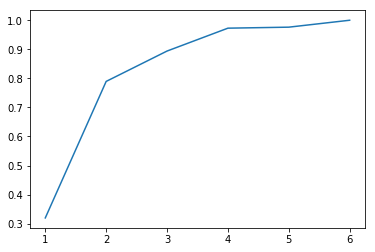

In [24]:
variance = []

for n in range(6):
    A_red, V, var = get_pca_reduction(A, n_components=n+1)
    variance.append(1.0*np.var(A_red, axis=0).sum() / np.var(A, axis=0).sum())

plt.plot(np.array([1.0*(n+1) for n in range(6)]), np.array(variance))

## 4.  PCA - NLP practical example 

## 4.1 - Start from baseline

We will now go back to our real example! We'll start from the same baseline as 2.1 

In [36]:
df = pd.read_csv('../datasets/twitter_rep_dem_data_small.csv')

# Feature Extraction
handle_remotion = lambda doc: re.subn(r'@\w+','', doc.lower())[0]
df['Tweet'] = df['Tweet'].map(handle_remotion)

simple_tokenizer = lambda doc: " ".join(WordPunctTokenizer().tokenize(doc))
df['Tweet'] = df['Tweet'].map(simple_tokenizer)

train_data, test_data = train_test_split(df, test_size=0.3, random_state=seed)
      
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data.Tweet)
X_test = vectorizer.transform(test_data.Tweet)

clf =  KNeighborsClassifier()
clf.fit(X_train, train_data.Party)
pred = clf.predict(X_test)

print('Baseline Accuracy: {}'.format(accuracy_score(pred, test_data.Party)))

Baseline Accuracy: 0.5062994960403168


## 4.2 - Applying PCA

We will now use the scikit-learn PCA class to obtain an our reduction. Once again, go grab that coffee and take a walk, cause this might take a while.

In [38]:
variance = []
accuracies = []

dense_X_train = X_train.toarray()
dense_X_test = X_test.toarray()
data_var = np.var(dense_X_train, axis=0).sum()

print('Total variance:')
print(data_var)

for n in [2, 10, 100, 200, 500]:
    print("\nComputing PCA for {} components".format(str(n)))
    pca = PCA(n_components=n, random_state=seed)
    % timeit pca.fit(dense_X_train)
    X_train_pca = pca.transform(dense_X_train)
    X_test_pca = pca.transform(dense_X_test)
    
    print('\nVariance:')
    print(np.var(X_train_pca, axis=0).sum())
    variance.append(1.0*np.var(X_train_pca, axis=0).sum() / data_var)
    
    clf =  KNeighborsClassifier()
    % timeit clf.fit(X_train_pca, train_data.Party)
    pred = clf.predict(X_test_pca)
    
    accuracies.append(accuracy_score(pred, test_data.Party))
    print('\nAccuracy: {}'.format(accuracy_score(pred, test_data.Party)))

Total variance:
0.9793720330999335

Computing PCA for 2 components
19.6 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.008843292423477856

Accuracy: 0.5260979121670266

Computing PCA for 10 components
21.6 s ± 2.16 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.0326690857536827

Accuracy: 0.5413966882649388

Computing PCA for 100 components
50.9 s ± 3.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.15257216765155285

Accuracy: 0.6042116630669546

Computing PCA for 200 components
1min 11s ± 3.47 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.22463714266185258

Accuracy: 0.6099712023038157

Computing PCA for 500 components
2min 21s ± 14.6 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.3579110314998868

Accuracy: 0.5950323974082073

Computing PCA for 1000 components
4min 27s ± 13.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

Variance:
0.4849306050751518

Accuracy: 0.56875449

Text(0.5,1,'PCA Variance')

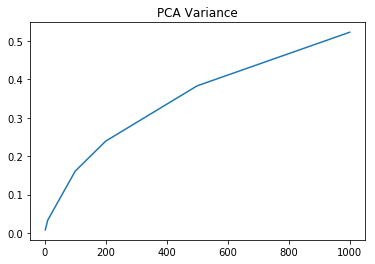

In [39]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(true_variance))
plt.title("PCA Variance")

Text(0.5,1,'PCA Accuracy')

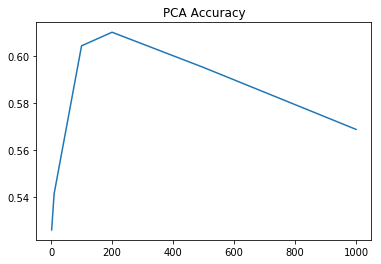

In [40]:
plt.plot(np.array([2.0, 10.0, 100.0, 200.0, 500.0, 1000.0]), np.array(accuracies))
plt.title("PCA Accuracy")

The results are similar to the ones obtained with SVD, which is intuitive since both methods try to obtain meaningful components that represent the data. As referred before, the use of this classifier points out the problems of high dimensionality data, and should show you that these methods can be very useful in solving that problem.

## Final Remarks

We went through PCA and SVD on this notebook, which are methods you can try out in virtually any kind of data, whether your purpose is compression, visualization or just dimensionality reduction for classification. Some final notes:

1 - You must have realized by now that the performance of the methods is tightly coupled to the classifier you choose, and that not always methods that intuitively seem to be good will help you in your tasks. This doesn't mean that the methods aren't good, simply that you need to first think of what model are you focusing on and whether you really need  or expect an improvement over your baseline.

2 - You can combine methods like this with other feature selection and engineering techniques you saw before. As in many fields, trying these techniques in different scenarios will give you a better sense on when these can be helpful or when they will actually be harmful.

We're finally done! Now rest a bit, go for a walk, and then dive into Part III. But before you go, I'll leave you with these questions:

<img src="../media/matrix-questions-existencial.jpg" width="700">

